In [2]:
%load_ext autoreload
%autoreload 2

import sys, os
import pandas as pd
import numpy as np
from tqdm import tqdm
import wandb
import matplotlib.pyplot as plt
import torch

sys.path.append(os.path.join(os.getcwd(), '../symlie'))
from misc.utils import NumpyUtils, Results, tensor_operation, numpy_operation, Args
from misc.viz import plot2d
from model.setup import find_id_for_P, load_P_pred
from model.networks.linear import CalculatedP
from misc.viz import plot2d
from data.generate_2d import sine1d, sine2d, flower, mnist
from data.generate_data import datasets
from data.dataset import FlatDataset

from misc.utils_results import plot_data, assert_unique, pivot, plot_pivot, add_df_map_new, assert_columns_same, get_and_check_Ps, plot_seeds_and_Ps, rename_net, stringify_dict
from misc.wandb import exceptions, new_runs

In [3]:
df_map_columns = ['run_id', 'tags', 'data_kwargs', 'transform_kwargs', 'seed', 'data_dir']

df = pd.read_pickle('../logs/store/results_df.pkl')
print(df.shape)
print(df.columns)
df.head()

(285, 41)
Index(['lr', 'net', 'bias', 'name', 'seed', 'tags', 'test', 'n_val', 'train',
       'y_low', 'device', 'logger', 'n_test', 'run_id', 'y_high', 'log_dir',
       'n_train', 'predict', 'version', 'data_dir', 'eps_mult', 'n_splits',
       'criterion', 'do_return', 'earlystop', 'grid_size', 'noise_std',
       'only_flip', 'batch_size', 'max_epochs', 'data_kwargs', 'num_workers',
       'generate_data', 'model_summary', 'args_processed', 'do_return_model',
       'transform_kwargs', 'persistent_workers', 'run_name', 'test_loss',
       'space_length'],
      dtype='object')


,lr,net,bias,name,seed,tags,test,n_val,train,y_low,...,num_workers,generate_data,model_summary,args_processed,do_return_model,transform_kwargs,persistent_workers,run_name,test_loss,space_length
0,0.010,Predict-TrainedP,False,None,1,"[mnist-noise-predict, mnist-predict]",True,1000,True,NaN,...,18,False,False,True,False,"{'eps_mult': [0, 1, 1, 1], 'only_flip': False}",True,tender-sweetheart-738,1.908377,NaN
1,0.001,Predict-TrainedP,False,None,1,"[mnist-noise-predict, mnist-predict]",True,1000,True,NaN,...,18,False,False,True,False,"{'eps_mult': [0, 1, 1, 1], 'only_flip': False}",True,deeply-etchings-738,2.239011,NaN
2,0.001,Predict-TrainedP,False,None,2,"[mnist-noise-predict, mnist-predict]",True,1000,True,NaN,...,18,False,False,True,False,"{'eps_mult': [0, 1, 1, 1], 'only_flip': False}",True,desiring-quiver-737,2.169616,NaN
3,0.010,Predict-TrainedP,False,None,3,"[mnist-noise-predict, mnist-predict]",True,1000,True,NaN,...,18,False,False,True,False,"{'eps_mult': [0, 1, 1, 1], 'only_flip': False}",True,engaging-balloon-736,1.971697,NaN
4,0.100,Predict-TrainedP,False,None,2,"[mnist-noise-predict, mnist-predict]",True,1000,True,NaN,...,18,False,False,True,False,"{'eps_mult': [0, 1, 1, 1], 'only_flip': False}",True,fiery-date-735,1.945251,NaN


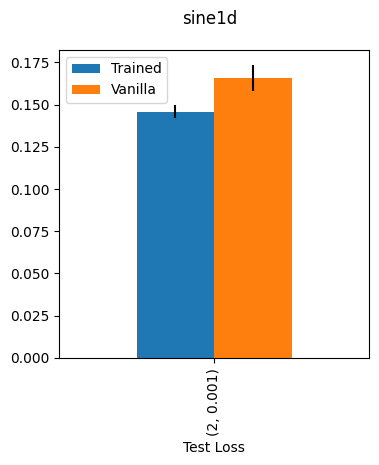

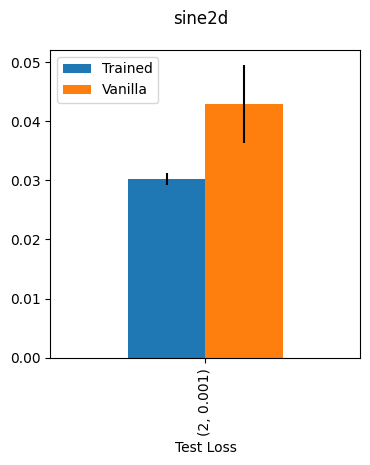

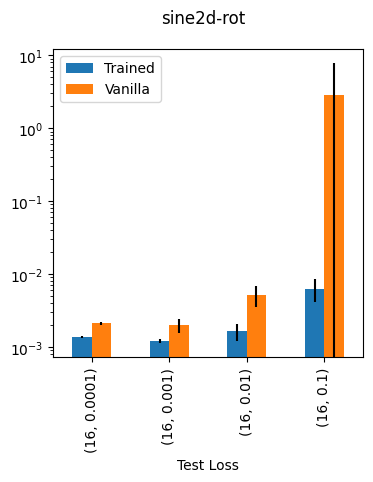

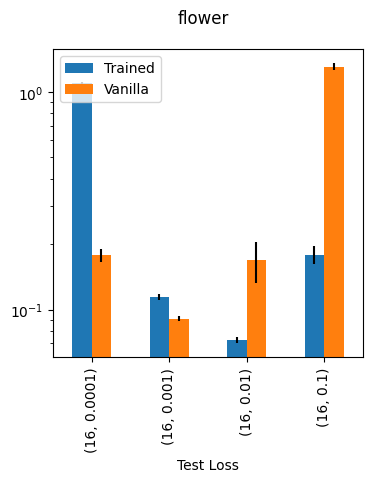

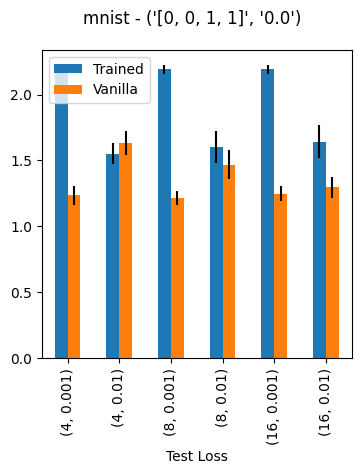

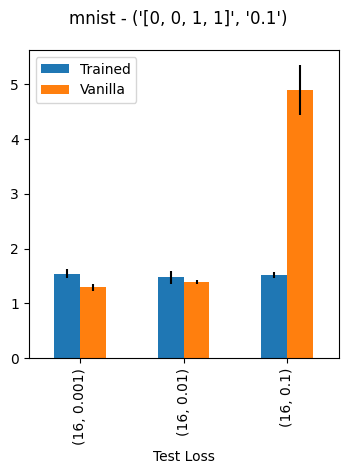

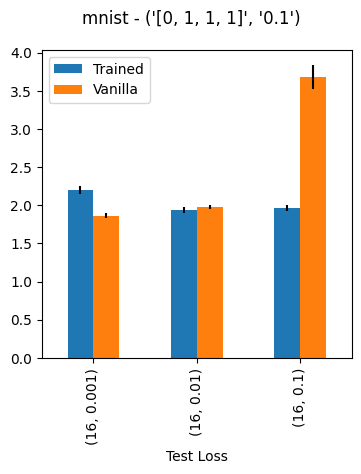

In [7]:
datasets_predict = {
    'sine1d' : {'log' : False},
    'sine2d' : {'log' : False},
    'sine2d-rot' : {'log' : True},
    'flower' : {'log' : True},
    'mnist' : {'log' : False, 'groupby' : ['eps_mult', 'noise_std']},
}

d_pivots = {}

for dataset_name, dataset_info in datasets_predict.items():
    d = df[df['tags'].astype(str).str.contains(f'{dataset_name}-predict')].reset_index(drop=True)

    if 'groupby' in dataset_info:
        d = stringify_dict(d, ['noise_std', 'eps_mult'])
        ds = {group : d_group for group, d_group in d.groupby(['eps_mult', 'noise_std'])}
    else:
        ds = {0 : d}

    for group, d in ds.items():

        d = d.reset_index(drop=True)

        for row in d['data_kwargs']:
            if 'grid_size' in row:
                row['grid_size'] = tuple(row['grid_size'])
        for row in d['transform_kwargs']:
            if 'eps_mult' in row:
                row['eps_mult'] = [float(x) for x in row['eps_mult']]

        d = d.drop_duplicates(subset=['seed', 'batch_size', 'lr', 'net', 'test_loss']) #TODO: why is this necessary?
        map_kwargs = assert_columns_same(d, ['data_kwargs', 'transform_kwargs'])



        d_pivot = pivot(d)
        d_pivot = rename_net(d_pivot)
        plot_pivot(d_pivot=d_pivot, legend_loc = 'upper left', logx=dataset_info['log'], suptitle = f'{dataset_name} - {group}' if group != 0 else f'{dataset_name}')
        d_pivots[(dataset_name, group)] = (d_pivot, map_kwargs)


In [1]:
n_plots = len(d_pivots)
plot_dir = 'x'


n_height, n_width = 1, n_plots if plot_dir == 'x' else n_plots, 1
fig, axs = plt.subplots(n_plots, 1, figsize=(5*n_height, 2*n_width), tight_layout=True)

for i, ((dataset_name, group), (d_pivot, map_kwargs)) in enumerate(d_pivots.items()):
    ax = axs[i]

    unstack = lambda d, metric: d.apply(metric).unstack().reset_index(level=0, drop = True)
    d_mean, d_std = unstack(d_pivot, pd.Series.mean), unstack(d_pivot, pd.Series.std)

    d_mean.plot(kind='barh', xerr=d_std, ax = ax, legend = False)
    ax.set_title(f'{dataset_name} - {group}')
    if i == 0: ax.legend(loc = 'upper center', bbox_to_anchor=(0.5, 1.5), ncol = 2)
    
    if datasets_predict[dataset_name]['log']: ax.set_xscale('log')

NameError: name 'd_pivots' is not defined